## **Table of Contents**

1. **Training the interpretable Decision Tree Model and visualizing the tree**
2. **Training the Random Forest Model and look at the feature importance**
3. **Global Surrogate**
4. **LIME to generate local intepretations of black box models**

In [3]:
# importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# reading the data
df = pd.read_csv('data.csv')

In [5]:
# data type of the variables
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [6]:
# first 5 rows of the data
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [7]:
# number of missing values in each variable
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
# imputing missing values in Item_Weight by median and Outlet_Size with mode
df['Item_Weight'].fillna(df['Item_Weight'].median(), inplace=True)
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)

## Feature Engineering

In [9]:
# creating a broad category of type of Items
df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda df: df[0:2])
df['Item_Type_Combined'] = df['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})

df['Item_Type_Combined'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Item_Type_Combined, dtype: int64

In [10]:
# operating years of the store
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']

In [11]:
# modifying categories of Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Pre-Processing the Data

In [12]:
# label encoding the ordinal variables
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [13]:
# one hot encoding the remaining categorical variables 
df = pd.get_dummies(df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [14]:
# dropping the ID variables and variables that have been used to extract new variables
df.drop(['Item_Type','Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier'],axis=1,inplace=True)

In [15]:
# separating the dependent and independent variables
X = df.drop('Item_Outlet_Sales',1)
y = df['Item_Outlet_Sales']

In [16]:
# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

## Training the interpretable Decision Tree Model and visualizing the tree

In [17]:
# creating a decision tree model
dt = DecisionTreeRegressor(max_depth = 5, random_state=10)

In [18]:
# fitting the decision tree model on the training set
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

In [19]:
# rmse on training set
np.sqrt(mean_squared_error(y_train,dt.predict(X_train)))

1082.6553744791681

In [20]:
# rmse on validation set
np.sqrt(mean_squared_error(y_test,dt.predict(X_test)))

1057.4530115283153

In [21]:
# creating the decision tree
decision_tree = tree.export_graphviz(dt, out_file='tree.dot', feature_names=X_train.columns, filled=True, max_depth=2)

In [22]:
# converting the dot image to png format
!dot -Tpng tree.dot -o tree.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


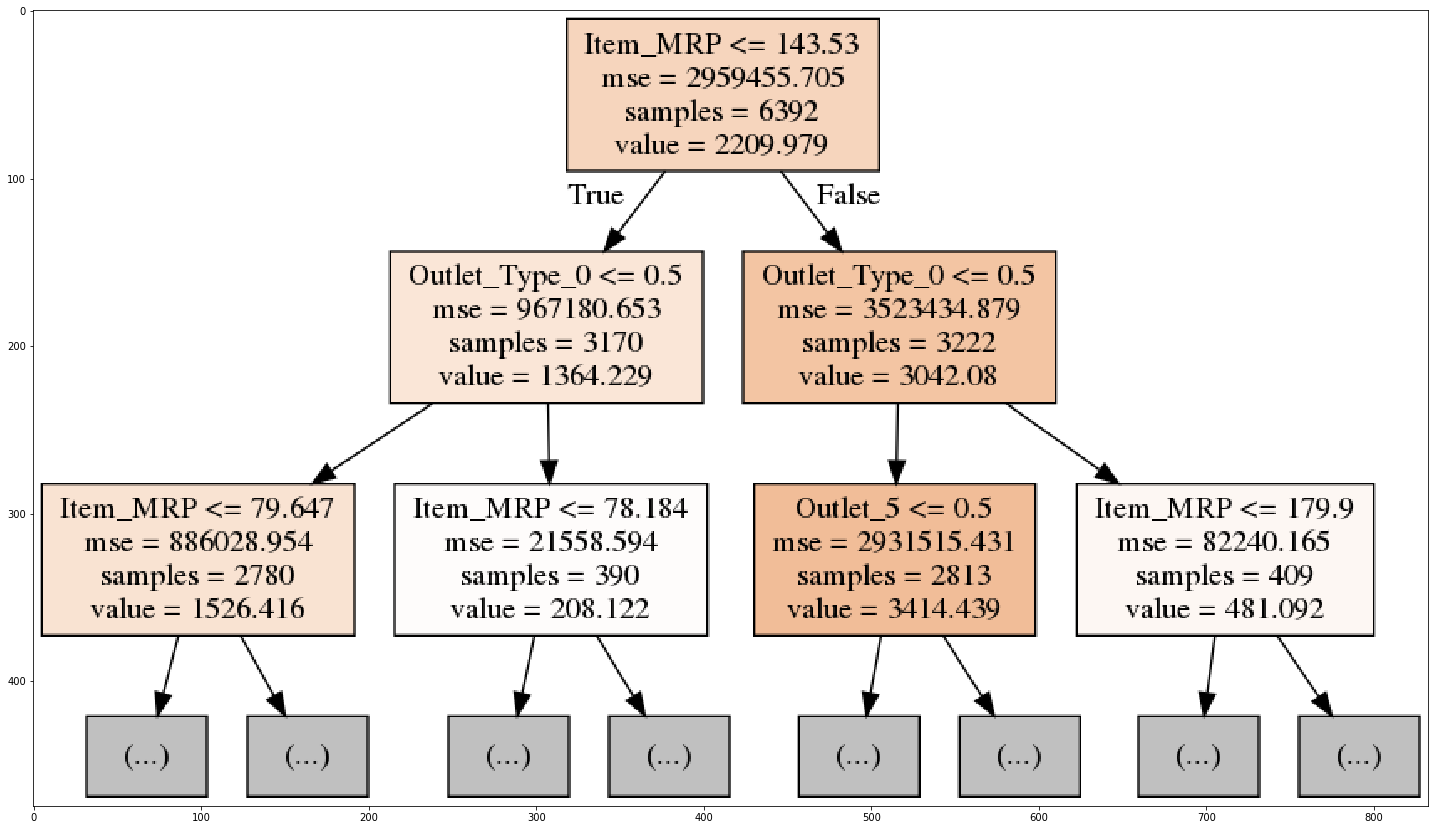

In [21]:
#plotting the decision tree
image = plt.imread('tree.png')
plt.figure(figsize=(25,25))
plt.imshow(image)

## Training the Random Forest Model and look at the feature importance

In [23]:
# creating the Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=100,n_jobs=-1)

In [24]:
# fitting the model using training set
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [25]:
# rmse on training set
np.sqrt(mean_squared_error(y_train,rf.predict(X_train)))

1087.4210331275399

In [26]:
# rmse on validation set
np.sqrt(mean_squared_error(y_test,rf.predict(X_test)))

1044.3727442847503

In [27]:
# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = X_train.columns
feature_importance['importance'] = rf.feature_importances_

In [28]:
# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(10)

variable  importance
2                 Item_MRP    0.551642
12           Outlet_Type_0    0.322000
3             Outlet_Years    0.048740
24                Outlet_5    0.040683
15           Outlet_Type_3    0.035790
1          Item_Visibility    0.000439
0              Item_Weight    0.000238
13           Outlet_Type_1    0.000156
10           Outlet_Size_1    0.000149
8   Outlet_Location_Type_2    0.000115

## Global Surrogate

In [29]:
# creating the black box Random Forest Regressor model
model = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=-1)

In [30]:
# fitting the model using training set
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [31]:
# rmse on training set
np.sqrt(mean_squared_error(y_train,model.predict(X_train)))

1087.8052165004879

In [32]:
# rmse on validation set
np.sqrt(mean_squared_error(y_test,model.predict(X_test)))

1044.1327404455758

In [33]:
# saving the predictions as new target
new_target = model.predict(X_train)

In [34]:
# defining the interpretable decision tree model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=10)

In [35]:
# fitting the surrogate decision tree model using the training set and new target
dt_model.fit(X_train,new_target)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

In [36]:
# rmse on training set
np.sqrt(mean_squared_error(y_train,dt_model.predict(X_train)))

1094.0473641351464

In [37]:
# rmse on validation set
np.sqrt(mean_squared_error(y_test,dt_model.predict(X_test)))

1048.71168919818

In [38]:
# creating the decision tree
decision_tree = tree.export_graphviz(dt_model, out_file='tree_1.dot', feature_names=X_train.columns, filled=True, max_depth=2)

In [39]:
# converting the dot image to png format
!dot -Tpng tree_1.dot -o tree_1.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


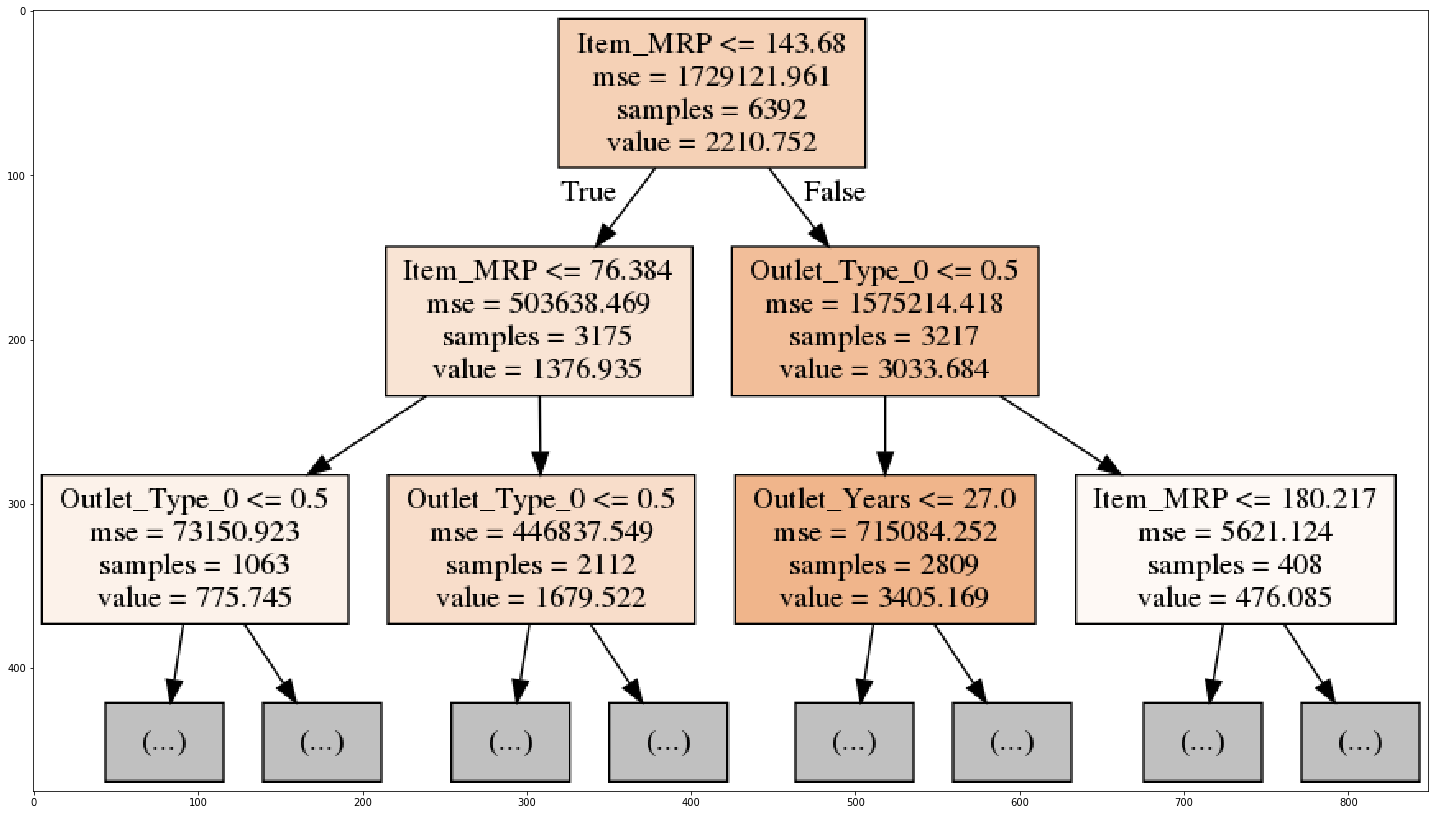

In [39]:
#plotting the decision tree
image = plt.imread('tree_1.png')
plt.figure(figsize=(25,25))
plt.imshow(image)

In [40]:
# feature importance of the decision tree model
feature_importance = pd.DataFrame()
feature_importance['variable'] = X_train.columns
feature_importance['importance'] = dt_model.feature_importances_

In [41]:
# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head()

variable  importance
2        Item_MRP    0.544898
12  Outlet_Type_0    0.333943
15  Outlet_Type_3    0.099938
24       Outlet_5    0.020918
3    Outlet_Years    0.000301

## LIME to generate local interpretations of black box models

In [ ]:
# installing lime library
!pip install lime

In [42]:
# import Explainer function from lime_tabular module of lime library
from lime.lime_tabular import LimeTabularExplainer

In [43]:
# training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
# rmse on validation set using the linear regression model
np.sqrt(mean_squared_error(y_test,lr_model.predict(X_test)))

1089.9432287387797

In [45]:
# training the decision tree model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=10)
dt_model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

In [46]:
# rmse on validation set using decision tree model
np.sqrt(mean_squared_error(y_test,dt_model.predict(X_test)))

1057.4530115283153

In [47]:
# training the random forest model
rf_model = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=-1, random_state=10)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [48]:
# rmse on validation set using random forest model
np.sqrt(mean_squared_error(y_test,rf_model.predict(X_test)))

1043.981654138004

In [50]:
# creating the explainer function
explainer = LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)

In [59]:
# storing a new observation
i = 11
X_observation = X_test.iloc[[i], :]
X_observation

Item_Weight  Item_Visibility  Item_MRP  Outlet_Years  \
1670         12.6         0.073229  254.1014            28   

      Item_Fat_Content_0  Item_Fat_Content_1  Outlet_Location_Type_0  \
1670                   1                   0                       1   

      Outlet_Location_Type_1  Outlet_Location_Type_2  Outlet_Size_0  ...  \
1670                       0                       0              0  ...   

      Outlet_0  Outlet_1  Outlet_2  Outlet_3  Outlet_4  Outlet_5  Outlet_6  \
1670         0         0         0         0         1         0         0   

      Outlet_7  Outlet_8  Outlet_9  
1670         0         0         0  

[1 rows x 29 columns]

In [60]:
# printing the true value, linear regression, random forest, decision tree predictions for the above observation
print(f"""\
* True prediction: {y_test.iloc[i]}
* LR prediction: {lr_model.predict(X_observation)[0]}
* DT prediction: {dt_model.predict(X_observation)[0]}
* RF prediction: {rf_model.predict(X_observation)[0]}""")

* True prediction: 255.0014
* LR prediction: 2130.1011857630774
* DT prediction: 559.1355655737705
* RF prediction: 555.4892518905921


In [61]:
# testing our custom function to make sure it generates propabilities properly
explanation = explainer.explain_instance(X_observation.values[0], rf_model.predict)

Now that we have generated our explanation, we have access to several representations. The most useful one when working in a notebook is `show_in_notebook`.


On the left it shows the prediction
* If you set `show_table=True`, you will see the table with the most important features for this observation on the right.

In [62]:
# visualizing the interpretations
explanation.show_in_notebook(show_table=True)

In [54]:
# accessing the coefficients, intercept R squared and the predicted value
print(explanation.local_exp)
print(explanation.intercept)
print(explanation.score)
print(explanation.predicted_value)

{0: [(2, -1739.6437099510983), (12, -1111.5199336925543), (24, -732.3432517922997), (15, -700.9545092779356), (19, -625.7977306589543), (23, -374.62740303824614), (13, 310.16588837746565), (3, -299.69537123161115), (25, 198.73270553593824), (27, 194.3277985491607)], 1: [(2, 1739.6437099510983), (12, 1111.5199336925543), (24, 732.3432517922997), (15, 700.9545092779356), (19, 625.7977306589543), (23, 374.62740303824614), (13, -310.16588837746565), (3, 299.69537123161115), (25, -198.73270553593824), (27, -194.3277985491607)]}
{0: 113.73247633417077, 1: 113.73247633417077}
0.6901797526412452
4731.898862922889


In [55]:
# explanation using the decision tree model
explanation = explainer.explain_instance(X_observation.values[0], dt_model.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.6331710425946622


In [56]:
# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], rf_model.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.6739607739061179
